In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

from osgeo import gdal
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd
import rasterio
import rioxarray as rxr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
plt.rcParams['font.family'] = 'Arial'
from matplotlib.ticker import MaxNLocator

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

In [2]:
inpath = 'C:/Users/bn_li/Desktop/manu1/data/'
outpath = 'D:/figs_manu1/'

## veg type mask

In [3]:
mask = xr.open_dataset(inpath + 'lc.nc')
mask1 = xr.open_dataset(inpath + 'elev_0.05.nc')
mask2 = xr.open_dataset(inpath + 'spi_mask.nc')
vari_mask1 = mask1['vari'].sel(time='2022-12-31').values.reshape(190,231)

def varimask_forest1(ds, elevations):
    
    mask_a = mask['vari'].values == 1
    mask_b = vari_mask1 < elevations
    mask_c = mask2['vari'].values <= 0
    combined_mask = mask_a & mask_b & mask_c
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        arr = vari_masked.copy() #### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)


def varimask_forest2(ds, elevations1, elevations2):
    
    mask_a = mask['vari'].values == 1
    mask_b = (vari_mask1 >= elevations1) & (vari_mask1 < elevations2)
    mask_c = mask2['vari'].values <= 0
    combined_mask = mask_a & mask_b & mask_c
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        arr = vari_masked.copy() #### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)


def varimask_forest3(ds, elevations):
    
    mask_a = mask['vari'].values == 1
    mask_b = vari_mask1 >= elevations
    mask_c = mask2['vari'].values <= 0
    combined_mask = mask_a & mask_b & mask_c
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        arr = vari_masked.copy() #### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## forest along elevation

In [4]:
############ ndvi
ele1 = 400
ele2 = 700
ele3 = 1000
ds_y = xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01','2022-12-31'))
ds1 = varimask_forest1(ds_y,ele1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat1 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(ds_y,ele1,ele2)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat2 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(ds_y,ele2,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat3 = y_list.reshape((365, -1), order='F')


ds1 = varimask_forest3(ds_y,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat4 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_3040\235838110.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_3040\235838110.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_3040\235838110.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a m

C:\Users\bn_li\AppData\Local\Temp\ipykernel_30292\2082149532.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


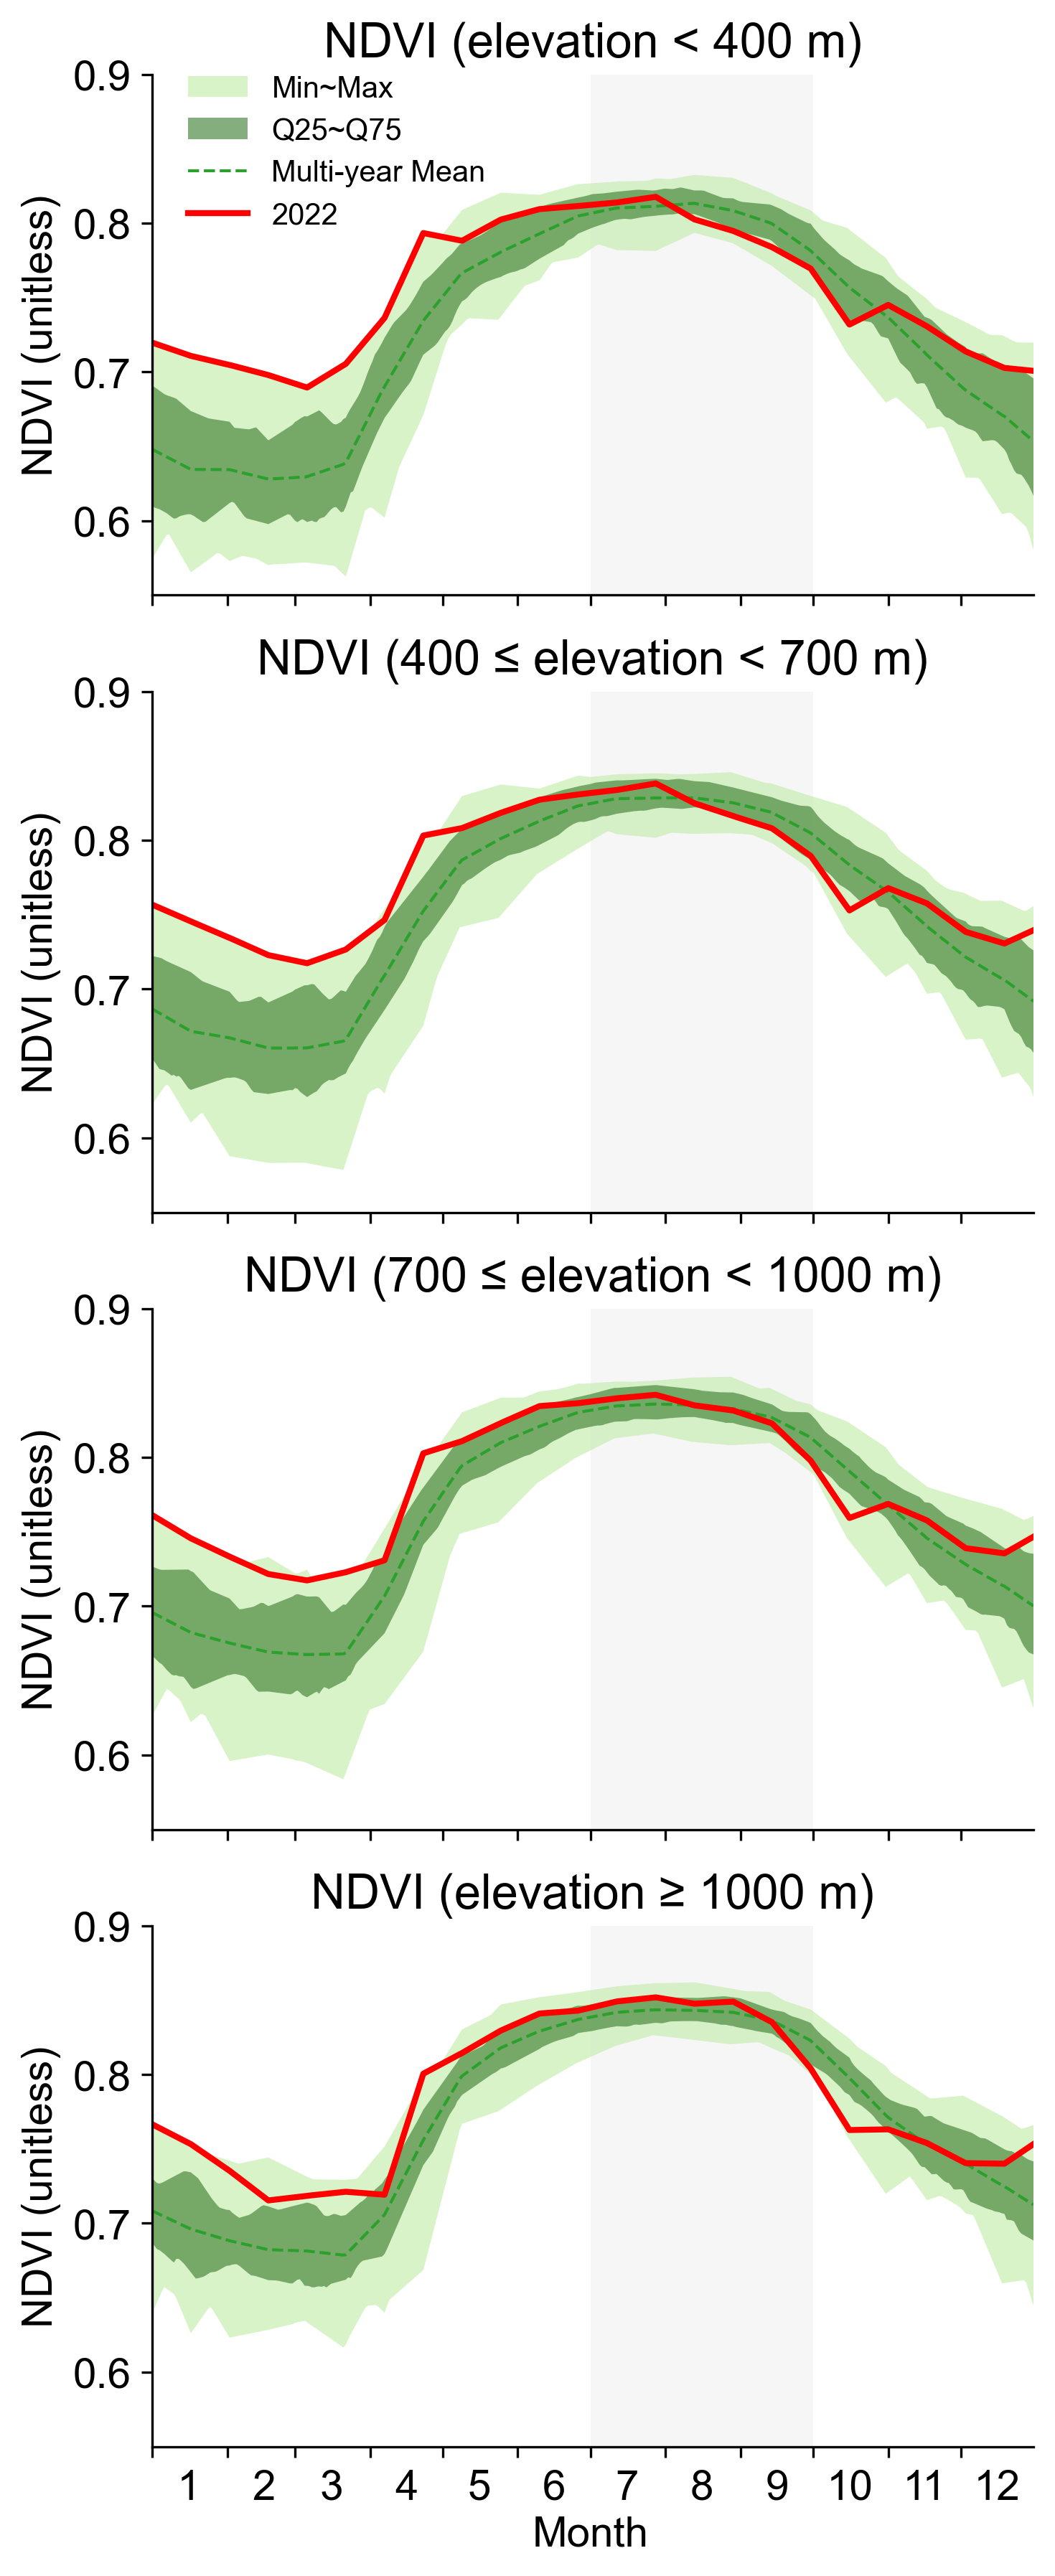

In [15]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(4,1,dpi = 300, figsize=(5,12))
date = np.arange(1,366)
date1 = np.arange(1,366)
axes_flat = axes.flatten()
data = [y_mat1,y_mat2, y_mat3,y_mat4]
title = [f"NDVI (elevation < {ele1} m)",f"NDVI ({ele1} ≤ elevation < {ele2} m)",f"NDVI ({ele2} ≤ elevation < {ele3} m)", f"NDVI (elevation ≥ {ele3} m)"]
ylabel = ['NDVI (unitless)','NDVI (unitless)','NDVI (unitless)','NDVI (unitless)']
# means = [3.77, 3.77, 3.60, 3.38]
# abnorms = [3.77+0.33, 3.77+0.47, 3.60+0.58, 3.38+0.64]
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.axvline(x=182, color='dimgrey', linestyle='--', lw=0.8)
        # ax.axvline(x=274, color='dimgrey', linestyle='--', lw=0.8)
        ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
        ax.fill_between(date, np.nanpercentile(data[i][:,:],q=0,axis=1),np.nanpercentile(data[i][:,:],q=100,axis=1), color='#C0EBA6',alpha=0.6,label='Min~Max',edgecolor='none')
        ax.fill_between(date, np.nanpercentile(data[i][:,:],q=25,axis=1),np.nanpercentile(data[i][:,:],q=75,axis=1), color='#347928',alpha=0.6,label='Q25~Q75',edgecolor='none')
        ax.plot(date,np.nanmean(data[i][:,:],axis=1),lw=1,ls='--',color='tab:green', label='Multi-year Mean')
        ax.plot(date1, data[i][:,-1],color='r',lw=2,label='2022')

        ax.set_xlim(date[0], date[-1])
        ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_ylabel(ylabel[i], fontsize=14)
        ax.set_title(title[i], fontsize=16)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.tick_params(axis='y', labelsize=14)
        ax.set_ylim(0.55, 0.9)
        # ax.axhline(y=means[i], color='tab:green', linestyle=':', lw=0.8,alpha=0.5)
        # ax.axhline(y=abnorms[i], color='r', linestyle=':', lw=0.8, alpha=0.5)


axes[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[1].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[2].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[3].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)

new_positions = [16, 47, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]
xticklabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
for ax in axes_flat:  # Bottom row of subplots
    # Keep the original ticks
    ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
    ax.set_xticklabels([])  # Hide the default labels

for label, pos in zip(xticklabels, new_positions):
    axes[3].text(
            pos, 
            ax.get_ylim()[0] - 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Slightly below the plot
            label, 
            ha='center', 
            va='center', 
            fontsize=14
        )
axes[3].text(182, ax.get_ylim()[0] - 0.17 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 'Month', ha='center', va='center', fontsize=14)
# plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()
plt.savefig(outpath+'8c.eps', dpi=1000, bbox_inches='tight') 
plt.show()

In [4]:
############ sif
ele1 = 400
ele2 = 700
ele3 = 1000
ds_y = xr.open_dataset(inpath+'shapley/sif_0.05_1d.nc').sel(time=slice('2001-01-01','2022-12-31'))
ds1 = varimask_forest1(ds_y,ele1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat1 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(ds_y,ele1,ele2)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat2 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(ds_y,ele2,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat3 = y_list.reshape((365, -1), order='F')


ds1 = varimask_forest3(ds_y,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat4 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_30292\235838110.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_30292\235838110.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_30292\235838110.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access 

C:\Users\bn_li\AppData\Local\Temp\ipykernel_30292\824009923.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


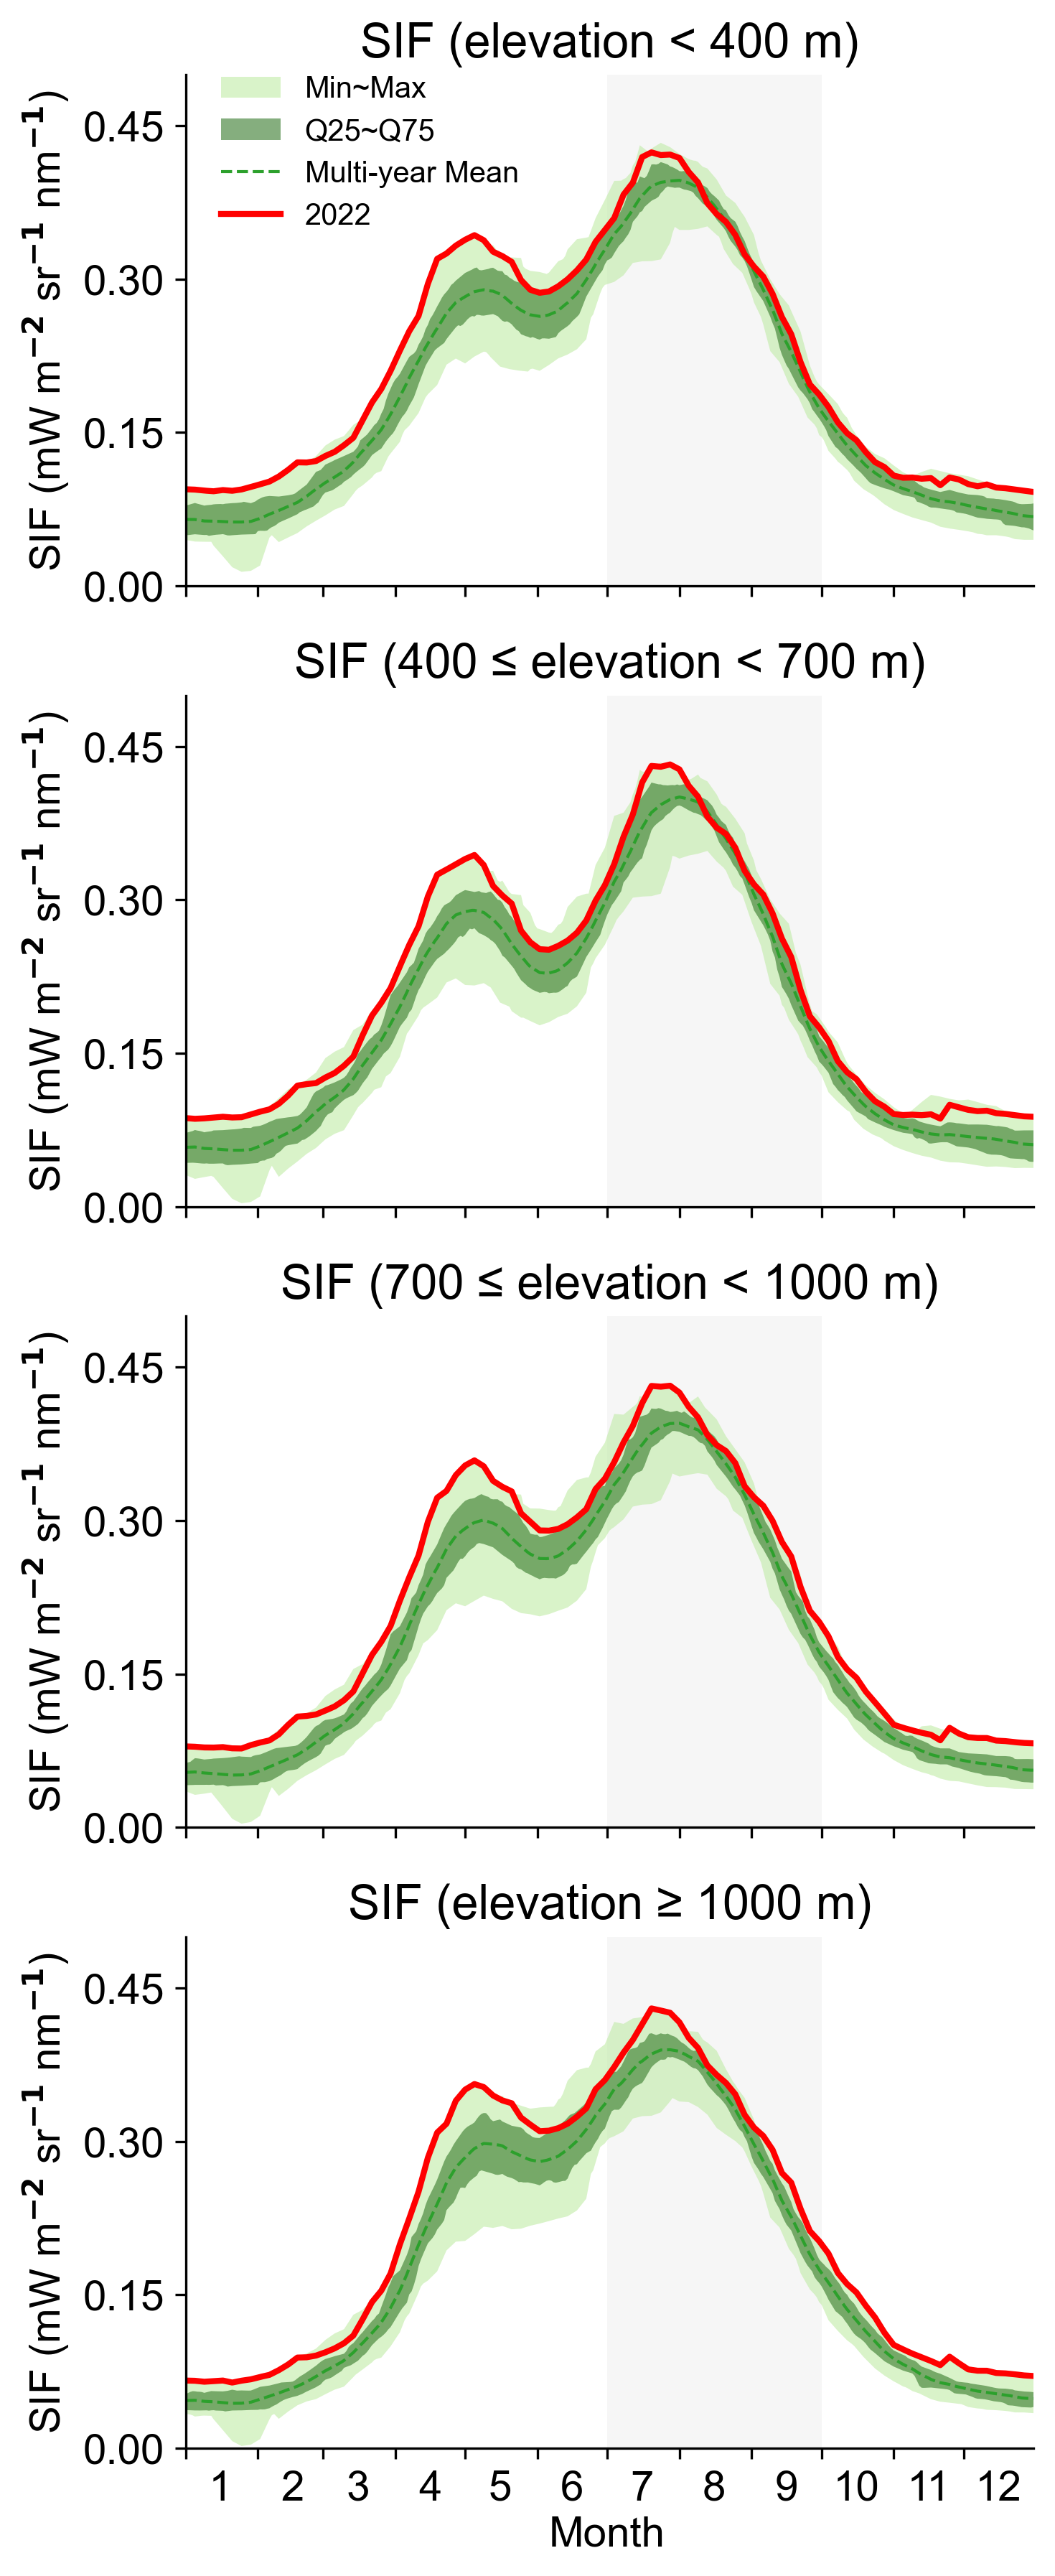

In [9]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(4,1,dpi = 300, figsize=(5,12))
date = np.arange(1,366)
date1 = np.arange(1,366)
axes_flat = axes.flatten()
data = [y_mat1,y_mat2, y_mat3,y_mat4]
title = [f"SIF (elevation < {ele1} m)",f"SIF ({ele1} ≤ elevation < {ele2} m)",f"SIF ({ele2} ≤ elevation < {ele3} m)", f"SIF (elevation ≥ {ele3} m)"]
ylabel = ['SIF (mW m$\mathbf{^{-2}}$ sr$\mathbf{^{-1}}$ nm$\mathbf{^{-1}}$)',
            'SIF (mW m$\mathbf{^{-2}}$ sr$\mathbf{^{-1}}$ nm$\mathbf{^{-1}}$)',
            'SIF (mW m$\mathbf{^{-2}}$ sr$\mathbf{^{-1}}$ nm$\mathbf{^{-1}}$)',
            'SIF (mW m$\mathbf{^{-2}}$ sr$\mathbf{^{-1}}$ nm$\mathbf{^{-1}}$)']
# means = [3.77, 3.77, 3.60, 3.38]
# abnorms = [3.77+0.33, 3.77+0.47, 3.60+0.58, 3.38+0.64]
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.axvline(x=182, color='dimgrey', linestyle='--', lw=0.8)
        # ax.axvline(x=274, color='dimgrey', linestyle='--', lw=0.8)
        ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
        ax.fill_between(date, np.nanpercentile(data[i][:,:],q=0,axis=1),np.nanpercentile(data[i][:,:],q=100,axis=1), color='#C0EBA6',alpha=0.6,label='Min~Max',edgecolor='none')
        ax.fill_between(date, np.nanpercentile(data[i][:,:],q=25,axis=1),np.nanpercentile(data[i][:,:],q=75,axis=1), color='#347928',alpha=0.6,label='Q25~Q75',edgecolor='none')
        ax.plot(date,np.nanmean(data[i][:,:],axis=1),lw=1,ls='--',color='tab:green', label='Multi-year Mean')
        ax.plot(date1, data[i][:,-1],color='r',lw=2,label='2022')

        ax.set_xlim(date[0], date[-1])
        ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_ylabel(ylabel[i], fontsize=14)
        ax.set_title(title[i], fontsize=16)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.tick_params(axis='y', labelsize=14)
        ax.set_ylim(0, 0.5)
        # ax.axhline(y=means[i], color='tab:green', linestyle=':', lw=0.8,alpha=0.5)
        # ax.axhline(y=abnorms[i], color='r', linestyle=':', lw=0.8, alpha=0.5)


axes[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[1].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[2].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[3].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)

new_positions = [16, 47, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]
xticklabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
for ax in axes_flat:  # Bottom row of subplots
    # Keep the original ticks
    ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
    ax.set_xticklabels([])  # Hide the default labels

for label, pos in zip(xticklabels, new_positions):
    axes[3].text(
            pos, 
            ax.get_ylim()[0] - 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Slightly below the plot
            label, 
            ha='center', 
            va='center', 
            fontsize=14
        )
axes[3].text(182, ax.get_ylim()[0] - 0.17 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 'Month', ha='center', va='center', fontsize=14)
# plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()
plt.savefig(outpath+'8b.eps', dpi=1000, bbox_inches='tight') 
plt.show()

In [5]:
################# LAI  ########################################
ele1 = 400
ele2 = 700
ele3 = 1000
ds_y = xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01','2022-12-31'))
ds1 = varimask_forest1(ds_y,ele1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat1 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(ds_y,ele1,ele2)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat2 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(ds_y,ele2,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat3 = y_list.reshape((365, -1), order='F')


ds1 = varimask_forest3(ds_y,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2001-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat4 = y_list.reshape((365, -1), order='F')

C:\Users\bn_li\AppData\Local\Temp\ipykernel_3040\235838110.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_3040\235838110.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_3040\235838110.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a m

In [6]:
means = np.nanmean(y_mat1[:,:],axis=1)
abnorm = y_mat1[:,-1]
diff = abnorm - means
a = diff[182:274].mean()
b = means[182:274].mean()
print(a,b)
means = np.nanmean(y_mat2[:,:],axis=1)
abnorm = y_mat2[:,-1]
diff = abnorm - means
a = diff[182:274].mean()
b = means[182:274].mean()
print(a,b)
means = np.nanmean(y_mat3[:,:],axis=1)
abnorm = y_mat3[:,-1]
diff = abnorm - means
a = diff[182:274].mean()
b = means[182:274].mean()
print(a,b)
means = np.nanmean(y_mat4[:,:],axis=1)
abnorm = y_mat4[:,-1]
diff = abnorm - means
a = diff[182:274].mean()
b = means[182:274].mean()
print(a,b)

0.3764060844461754 3.832261531694025
0.5233904177093225 3.8240765569673583
0.5959333353421644 3.610382762141766
0.6618031570261637 3.391506856086123


C:\Users\bn_li\AppData\Local\Temp\ipykernel_18804\113300740.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


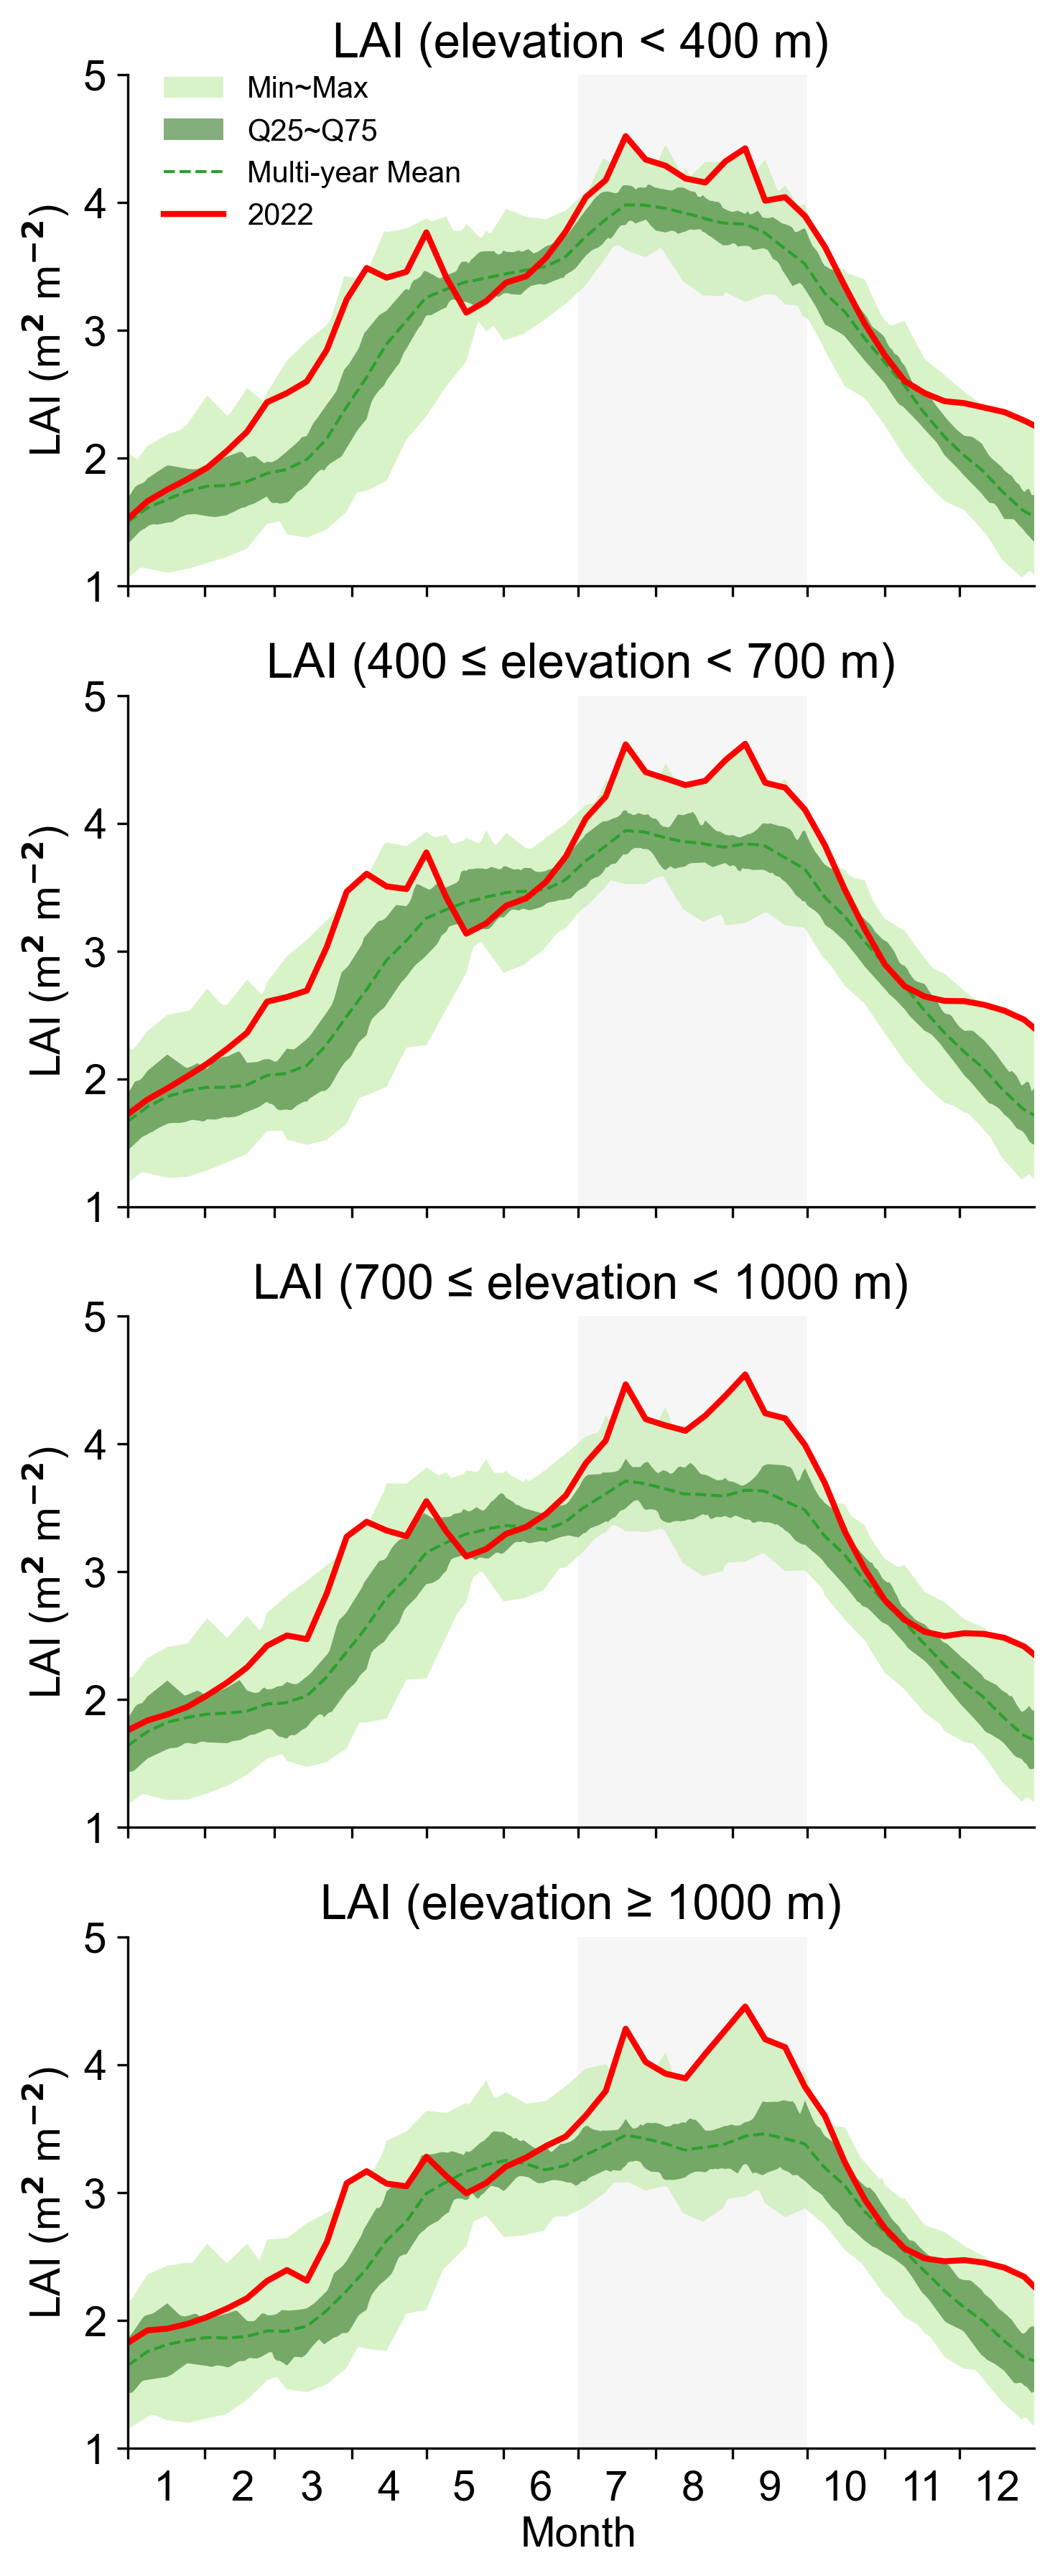

In [7]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(4,1,dpi = 300, figsize=(5,12))
date = np.arange(1,366)
date1 = np.arange(1,366)
axes_flat = axes.flatten()
data = [y_mat1,y_mat2, y_mat3,y_mat4]
title = [f"LAI (elevation < {ele1} m)",f"LAI ({ele1} ≤ elevation < {ele2} m)",f"LAI ({ele2} ≤ elevation < {ele3} m)", f"LAI (elevation ≥ {ele3} m)"]
ylabel = ['LAI (m$\mathbf{^{2}}$ m$\mathbf{^{-2}}$)','LAI (m$\mathbf{^{2}}$ m$\mathbf{^{-2}}$)','LAI (m$\mathbf{^{2}}$ m$\mathbf{^{-2}}$)','LAI (m$\mathbf{^{2}}$ m$\mathbf{^{-2}}$)']
# means = [3.77, 3.77, 3.60, 3.38]
# abnorms = [3.77+0.33, 3.77+0.47, 3.60+0.58, 3.38+0.64]
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.axvline(x=182, color='dimgrey', linestyle='--', lw=0.8)
        # ax.axvline(x=274, color='dimgrey', linestyle='--', lw=0.8)
        ax.axvspan(182, 274, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
        ax.fill_between(date, np.nanpercentile(data[i][:,:],q=0,axis=1),np.nanpercentile(data[i][:,:],q=100,axis=1), color='#C0EBA6',alpha=0.6,label='Min~Max',edgecolor='none')
        ax.fill_between(date, np.nanpercentile(data[i][:,:],q=25,axis=1),np.nanpercentile(data[i][:,:],q=75,axis=1), color='#347928',alpha=0.6,label='Q25~Q75',edgecolor='none')
        ax.plot(date,np.nanmean(data[i][:,:],axis=1),lw=1,ls='--',color='tab:green', label='Multi-year Mean')
        ax.plot(date1, data[i][:,-1],color='r',lw=2,label='2022')

        ax.set_xlim(date[0], date[-1])
        ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_ylabel(ylabel[i], fontsize=14)
        ax.set_title(title[i], fontsize=16)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.tick_params(axis='y', labelsize=14)
        ax.set_ylim(1, 5)
        # ax.axhline(y=means[i], color='tab:green', linestyle=':', lw=0.8,alpha=0.5)
        # ax.axhline(y=abnorms[i], color='r', linestyle=':', lw=0.8, alpha=0.5)


axes[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[1].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[2].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
# axes[3].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)

new_positions = [16, 47, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]
xticklabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
for ax in axes_flat:  # Bottom row of subplots
    # Keep the original ticks
    ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
    ax.set_xticklabels([])  # Hide the default labels

for label, pos in zip(xticklabels, new_positions):
    axes[3].text(
            pos, 
            ax.get_ylim()[0] - 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Slightly below the plot
            label, 
            ha='center', 
            va='center', 
            fontsize=14
        )
axes[3].text(182, ax.get_ylim()[0] - 0.17 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 'Month', ha='center', va='center', fontsize=14)
# plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()
plt.savefig(outpath+'8a.eps', dpi=1000, bbox_inches='tight') 
plt.show()

## sm & rn

In [ ]:
ele1 = 400
ele2 = 700
ele3 = 1000
x2 = xr.open_dataset(inpath+'shp/rn1.nc').sel(time=slice('2003-01-01','2022-12-31'))
fo1 = varimask_forest1(x2,ele1)
fo2 = varimask_forest2(x2,ele1,ele2)
fo3 = varimask_forest2(x2,ele2,ele3)
fo4 = varimask_forest3(x2,ele3)
bb1 = fo1['vari'].mean(dim=['lat','lon'],skipna=True).values.reshape((12, -1), order='F')
bb2 = fo2['vari'].mean(dim=['lat','lon'],skipna=True).values.reshape((12, -1), order='F')
bb3 = fo3['vari'].mean(dim=['lat','lon'],skipna=True).values.reshape((12, -1), order='F')
bb4 = fo4['vari'].mean(dim=['lat','lon'],skipna=True).values.reshape((12, -1), order='F')
df = pd.DataFrame(bb1, columns=[f'Column_{i+1}' for i in range(bb1.shape[1])])
b1 = df.values/(10**7)
df = pd.DataFrame(bb2, columns=[f'Column_{i+1}' for i in range(bb2.shape[1])])
b2 = df.values/(10**7)
df = pd.DataFrame(bb3, columns=[f'Column_{i+1}' for i in range(bb3.shape[1])])
b3 = df.values/(10**7)
df = pd.DataFrame(bb4, columns=[f'Column_{i+1}' for i in range(bb4.shape[1])])
b4 = df.values/(10**7)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [8]:
x2 = xr.open_dataset(datapath+'shp/t1.nc').sel(time=slice('2003-01-01','2022-12-31'))
fo1 = varimask_forest1(x2,ele1)
fo2 = varimask_forest2(x2,ele1,ele2)
fo3 = varimask_forest2(x2,ele2,ele3)
fo4 = varimask_forest3(x2,ele3)
cc1 = fo1['vari'].mean(dim=['lat','lon'],skipna=True).values.reshape((12, -1), order='F')
cc2 = fo2['vari'].mean(dim=['lat','lon'],skipna=True).values.reshape((12, -1), order='F')
cc3 = fo3['vari'].mean(dim=['lat','lon'],skipna=True).values.reshape((12, -1), order='F')
cc4 = fo4['vari'].mean(dim=['lat','lon'],skipna=True).values.reshape((12, -1), order='F')
df = pd.DataFrame(cc1, columns=[f'Column_{i+1}' for i in range(cc1.shape[1])])
c1 = df.values
df = pd.DataFrame(cc2, columns=[f'Column_{i+1}' for i in range(cc2.shape[1])])
c2 = df.values
df = pd.DataFrame(cc3, columns=[f'Column_{i+1}' for i in range(cc3.shape[1])])
c3 = df.values
df = pd.DataFrame(cc4, columns=[f'Column_{i+1}' for i in range(cc4.shape[1])])
c4 = df.values

In [4]:
ele1 = 400
ele2 = 700
ele3 = 1000

sm0 = xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc').sel(time = slice('2016-01-01', '2022-12-31'))
sm1 = xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc').sel(time = slice('2022-01-01', '2022-12-31'))

ds1 = varimask_forest1(sm0,ele1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2016-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat1 = y_list.reshape((365, -1), order='F')


ds1 = varimask_forest2(sm0,ele1,ele2)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2016-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat2 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(sm0,ele2,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2016-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat3 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest3(sm0,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2016-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat4 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest1(sm1,ele1)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat5 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(sm1,ele1,ele2)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat6 = y_list.reshape((365, -1), order='F')

ds1 = varimask_forest2(sm1,ele2,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat7 = y_list.reshape((365, -1), order='F')


ds1 = varimask_forest3(sm1,ele3)
varis = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
df0 = pd.DataFrame({'time':times,'y': varis})
df0.set_index('time',inplace=True)
df1 = df0[~((df0.index.month == 2) & (df0.index.day == 29))]
y_list = df1['y'].values
y_mat8 = y_list.reshape((365, -1), order='F')

df = pd.DataFrame(y_mat1, columns=[f'Column_{i+1}' for i in range(y_mat1.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a1 = df_roll.values*100

df = pd.DataFrame(y_mat2, columns=[f'Column_{i+1}' for i in range(y_mat2.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a2 = df_roll.values*100

df = pd.DataFrame(y_mat3, columns=[f'Column_{i+1}' for i in range(y_mat3.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a3 = df_roll.values*100

df = pd.DataFrame(y_mat4, columns=[f'Column_{i+1}' for i in range(y_mat4.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a4 = df_roll.values*100

df = pd.DataFrame(y_mat5, columns=[f'Column_{i+1}' for i in range(y_mat5.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a5 = df_roll.values*100

df = pd.DataFrame(y_mat6, columns=[f'Column_{i+1}' for i in range(y_mat6.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a6 = df_roll.values*100

df = pd.DataFrame(y_mat7, columns=[f'Column_{i+1}' for i in range(y_mat7.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a7 = df_roll.values*100

df = pd.DataFrame(y_mat8, columns=[f'Column_{i+1}' for i in range(y_mat8.shape[1])])
df_roll = df.rolling(window=10).mean()
df_roll = df_roll.fillna(method='bfill')
a8 = df_roll.values*100

C:\Users\bn_li\AppData\Local\Temp\ipykernel_30880\235838110.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_30880\235838110.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):    #### change the time length
C:\Users\bn_li\AppData\Local\Temp\ipykernel_30880\235838110.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access 

In [ ]:
# ############################################ MONTHLY SM ############################################
# sm0 = xr.open_dataset(datapath+'sm_0.05_2015_2021.nc').sel(time = slice('2016-01-01', '2021-12-31'))
# sm1 = xr.open_dataset(datapath+'sm_0.05_2022.nc')

# ds1 = varimask_forest1(sm0,ele1)
# ds2 = ds1.resample(time='M').mean(skipna=True)
# varis = ds2['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range(start='2016-01-01', end='2021-12-31', freq='M')
# df0 = pd.DataFrame({'time':times,'y': varis})
# df0.set_index('time',inplace=True)
# y_list = df0['y'].values
# y_mat1 = y_list.reshape((12, -1), order='F')

# ds1 = varimask_forest2(sm0,ele1,ele2)
# ds2 = ds1.resample(time='M').mean(skipna=True)
# varis = ds2['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range(start='2016-01-01', end='2021-12-31', freq='M')
# df0 = pd.DataFrame({'time':times,'y': varis})
# df0.set_index('time',inplace=True)
# y_list = df0['y'].values
# y_mat2 = y_list.reshape((12, -1), order='F')

# ds1 = varimask_forest2(sm0,ele2,ele3)
# ds2 = ds1.resample(time='M').mean(skipna=True)
# varis = ds2['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range(start='2016-01-01', end='2021-12-31', freq='M')
# df0 = pd.DataFrame({'time':times,'y': varis})
# df0.set_index('time',inplace=True)
# y_list = df0['y'].values
# y_mat3 = y_list.reshape((12, -1), order='F')

# ds1 = varimask_forest3(sm0,ele3)
# ds2 = ds1.resample(time='M').mean(skipna=True)
# varis = ds2['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range(start='2016-01-01', end='2021-12-31', freq='M')
# df0 = pd.DataFrame({'time':times,'y': varis})
# df0.set_index('time',inplace=True)
# y_list = df0['y'].values
# y_mat4 = y_list.reshape((12, -1), order='F')

# ds1 = varimask_forest1(sm1,ele1)
# ds2 = ds1.resample(time='M').mean(skipna=True)
# varis = ds2['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range(start='2022-01-01', end='2022-09-30', freq='M')
# df0 = pd.DataFrame({'time':times,'y': varis})
# df0.set_index('time',inplace=True)
# y_list = df0['y'].values
# y_mat5 = y_list.reshape((9, -1), order='F')

# ds1 = varimask_forest2(sm1,ele1,ele2)
# ds2 = ds1.resample(time='M').mean(skipna=True)
# varis = ds2['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range(start='2022-01-01', end='2022-09-30', freq='M')
# df0 = pd.DataFrame({'time':times,'y': varis})
# df0.set_index('time',inplace=True)
# y_list = df0['y'].values
# y_mat6 = y_list.reshape((9, -1), order='F')

# ds1 = varimask_forest2(sm1,ele2,ele3)
# ds2 = ds1.resample(time='M').mean(skipna=True)
# varis = ds2['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range(start='2022-01-01', end='2022-09-30', freq='M')
# df0 = pd.DataFrame({'time':times,'y': varis})
# df0.set_index('time',inplace=True)
# y_list = df0['y'].values
# y_mat7 = y_list.reshape((9, -1), order='F')


# ds1 = varimask_forest3(sm1,ele3)
# ds2 = ds1.resample(time='M').mean(skipna=True)
# varis = ds2['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range(start='2022-01-01', end='2022-09-30', freq='M')
# df0 = pd.DataFrame({'time':times,'y': varis})
# df0.set_index('time',inplace=True)
# y_list = df0['y'].values
# y_mat8 = y_list.reshape((9, -1), order='F')

# df = pd.DataFrame(y_mat1, columns=[f'Column_{i+1}' for i in range(y_mat1.shape[1])])
# a1 = df.values*100

# df = pd.DataFrame(y_mat2, columns=[f'Column_{i+1}' for i in range(y_mat2.shape[1])])
# a2 = df.values*100

# df = pd.DataFrame(y_mat3, columns=[f'Column_{i+1}' for i in range(y_mat3.shape[1])])
# a3 = df.values*100

# df = pd.DataFrame(y_mat4, columns=[f'Column_{i+1}' for i in range(y_mat4.shape[1])])
# a4 = df.values*100

# df = pd.DataFrame(y_mat5, columns=[f'Column_{i+1}' for i in range(y_mat5.shape[1])])
# a5 = df.values*100

# df = pd.DataFrame(y_mat6, columns=[f'Column_{i+1}' for i in range(y_mat6.shape[1])])
# a6 = df.values*100

# df = pd.DataFrame(y_mat7, columns=[f'Column_{i+1}' for i in range(y_mat7.shape[1])])
# a7 = df.values*100

# df = pd.DataFrame(y_mat8, columns=[f'Column_{i+1}' for i in range(y_mat8.shape[1])])
# a8 = df.values*100

C:\Users\bn_li\AppData\Local\Temp\ipykernel_13632\127992716.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_13632\127992716.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_13632\127992716.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(0, d

## hydroclimate plt

In [ ]:
means = np.nanmean(a1,axis=1)[:]
abnorm = a5
diff = abnorm - means
a = diff[91:152].mean()
b = means[91:152].mean()
print(a,b)
means = np.nanmean(a2,axis=1)[:]
abnorm = a6
diff = abnorm - means
a = diff[91:152].mean()
b = means[91:152].mean()
print(a,b)
means = np.nanmean(a3,axis=1)[:]
abnorm = a7
diff = abnorm - means
a = diff[91:152].mean()
b = means[91:152].mean()
print(a,b)
means = np.nanmean(a4,axis=1)[:]
abnorm = a8
diff = abnorm - means
a = diff[91:152].mean()
b = means[91:152].mean()
print(a,b)

6.320371037440871 38.3960673224048
6.9304867265504715 36.23548065131425
7.06669399723602 34.884457491435825
8.47176174960125 34.17933587174958


C:\Users\bn_li\AppData\Local\Temp\ipykernel_30880\3436445525.py:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(91, 182, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


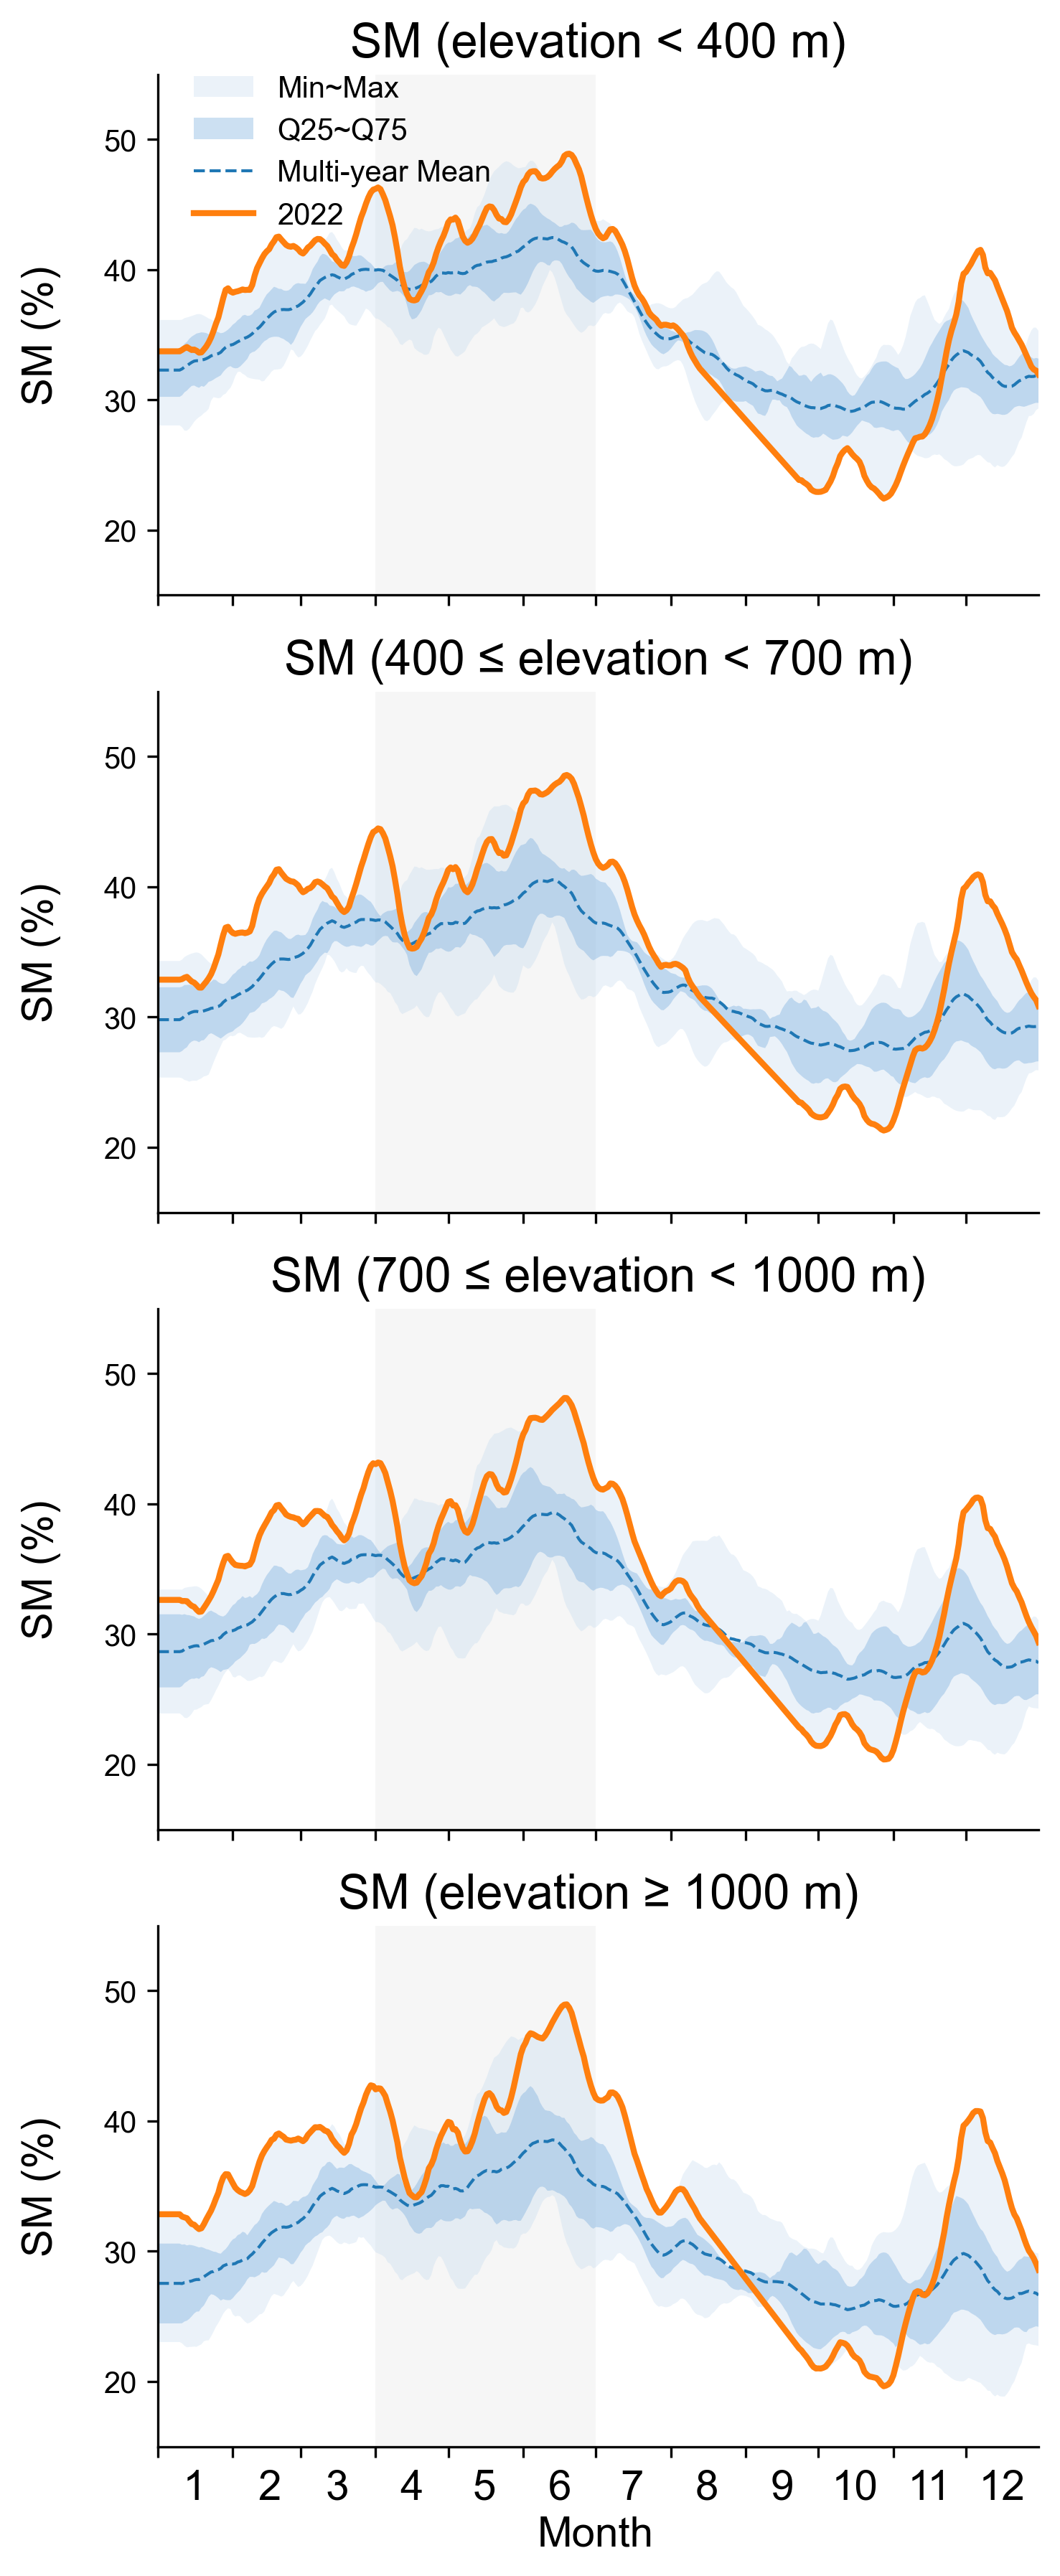

In [5]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(4,1,dpi=300,figsize=(5,12))
date = np.arange(1,366)
date1 = np.arange(1,366)
axes_flat = axes.flatten()
data = [a1,a2, a3,a4]
data1 = [a5,a6, a7,a8] ##a-sm
title = [f"SM (elevation < {ele1} m)",f"SM ({ele1} ≤ elevation < {ele2} m)",f"SM ({ele2} ≤ elevation < {ele3} m)", f"SM (elevation ≥ {ele3} m)"]
means = [38.40, 36.24, 34.88, 34.18]
abnorms = [38.40+6.32, 36.24+6.93, 34.88+7.07, 34.18+8.47]
for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axvspan(91, 182, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_tick_params(labelleft=False, labelright=False)
        ax.fill_between(date, np.nanpercentile(data[i],q=0,axis=1),np.nanpercentile(data[i],q=100,axis=1), color='#BDD7EE',alpha=0.3,label='Min~Max',edgecolor='none')
        ax.fill_between(date, np.nanpercentile(data[i],q=25,axis=1),np.nanpercentile(data[i],q=75,axis=1), color='#599AD7',alpha=0.3,label='Q25~Q75',edgecolor='none')
        ax.plot(date,np.nanmean(data[i],axis=1),lw=1,ls='--',color='tab:blue', label='Multi-year Mean')
        ax.plot(date1, data1[i],color='tab:orange',lw=2,label='2022')
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_title(title[i], fontsize=16)
        ax.spines['left'].set_position(('outward', 0))
        # ax.spines['left'].set_color('tab:blue')
        ax.yaxis.set_ticks_position('left') 
        # ax.yaxis.set_tick_params(labelleft=True, labelright=False, color='tab:blue', labelcolor='tab:blue')
        ax.set_ylabel('SM (%)',labelpad=15, fontsize=14)
        ax.yaxis.set_label_coords(-0.11, 0.5)
        ax.set_ylim(15,55)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        # ax.axhline(y=means[i], color='tab:blue', linestyle=':', lw=0.8,alpha=0.5)
        # ax.axhline(y=abnorms[i], color='tab:orange', linestyle=':', lw=0.8,alpha=0.5)

        

new_positions = [16, 47, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]
xticklabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
for ax in axes_flat:  # Bottom row of subplots
    # Keep the original ticks
    ax.set_xlim(date[0], date[-1])
    ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
    ax.set_xticklabels([])  # Hide the default labels

    # Add new labels at the desired positions
for label, pos in zip(xticklabels, new_positions):
    axes[3].text(
        pos, 
        ax.get_ylim()[0] - 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Slightly below the plot
        label, 
        ha='center', 
        va='center', 
        fontsize=14
    )
axes[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
axes[3].text(182, ax.get_ylim()[0] - 0.17 * (ax.get_ylim()[1] - ax.get_ylim()[0]), 'Month', ha='center', va='center', fontsize=14)

# plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()
plt.savefig(outpath+'s5.eps', dpi=1000, bbox_inches='tight') 
plt.show()

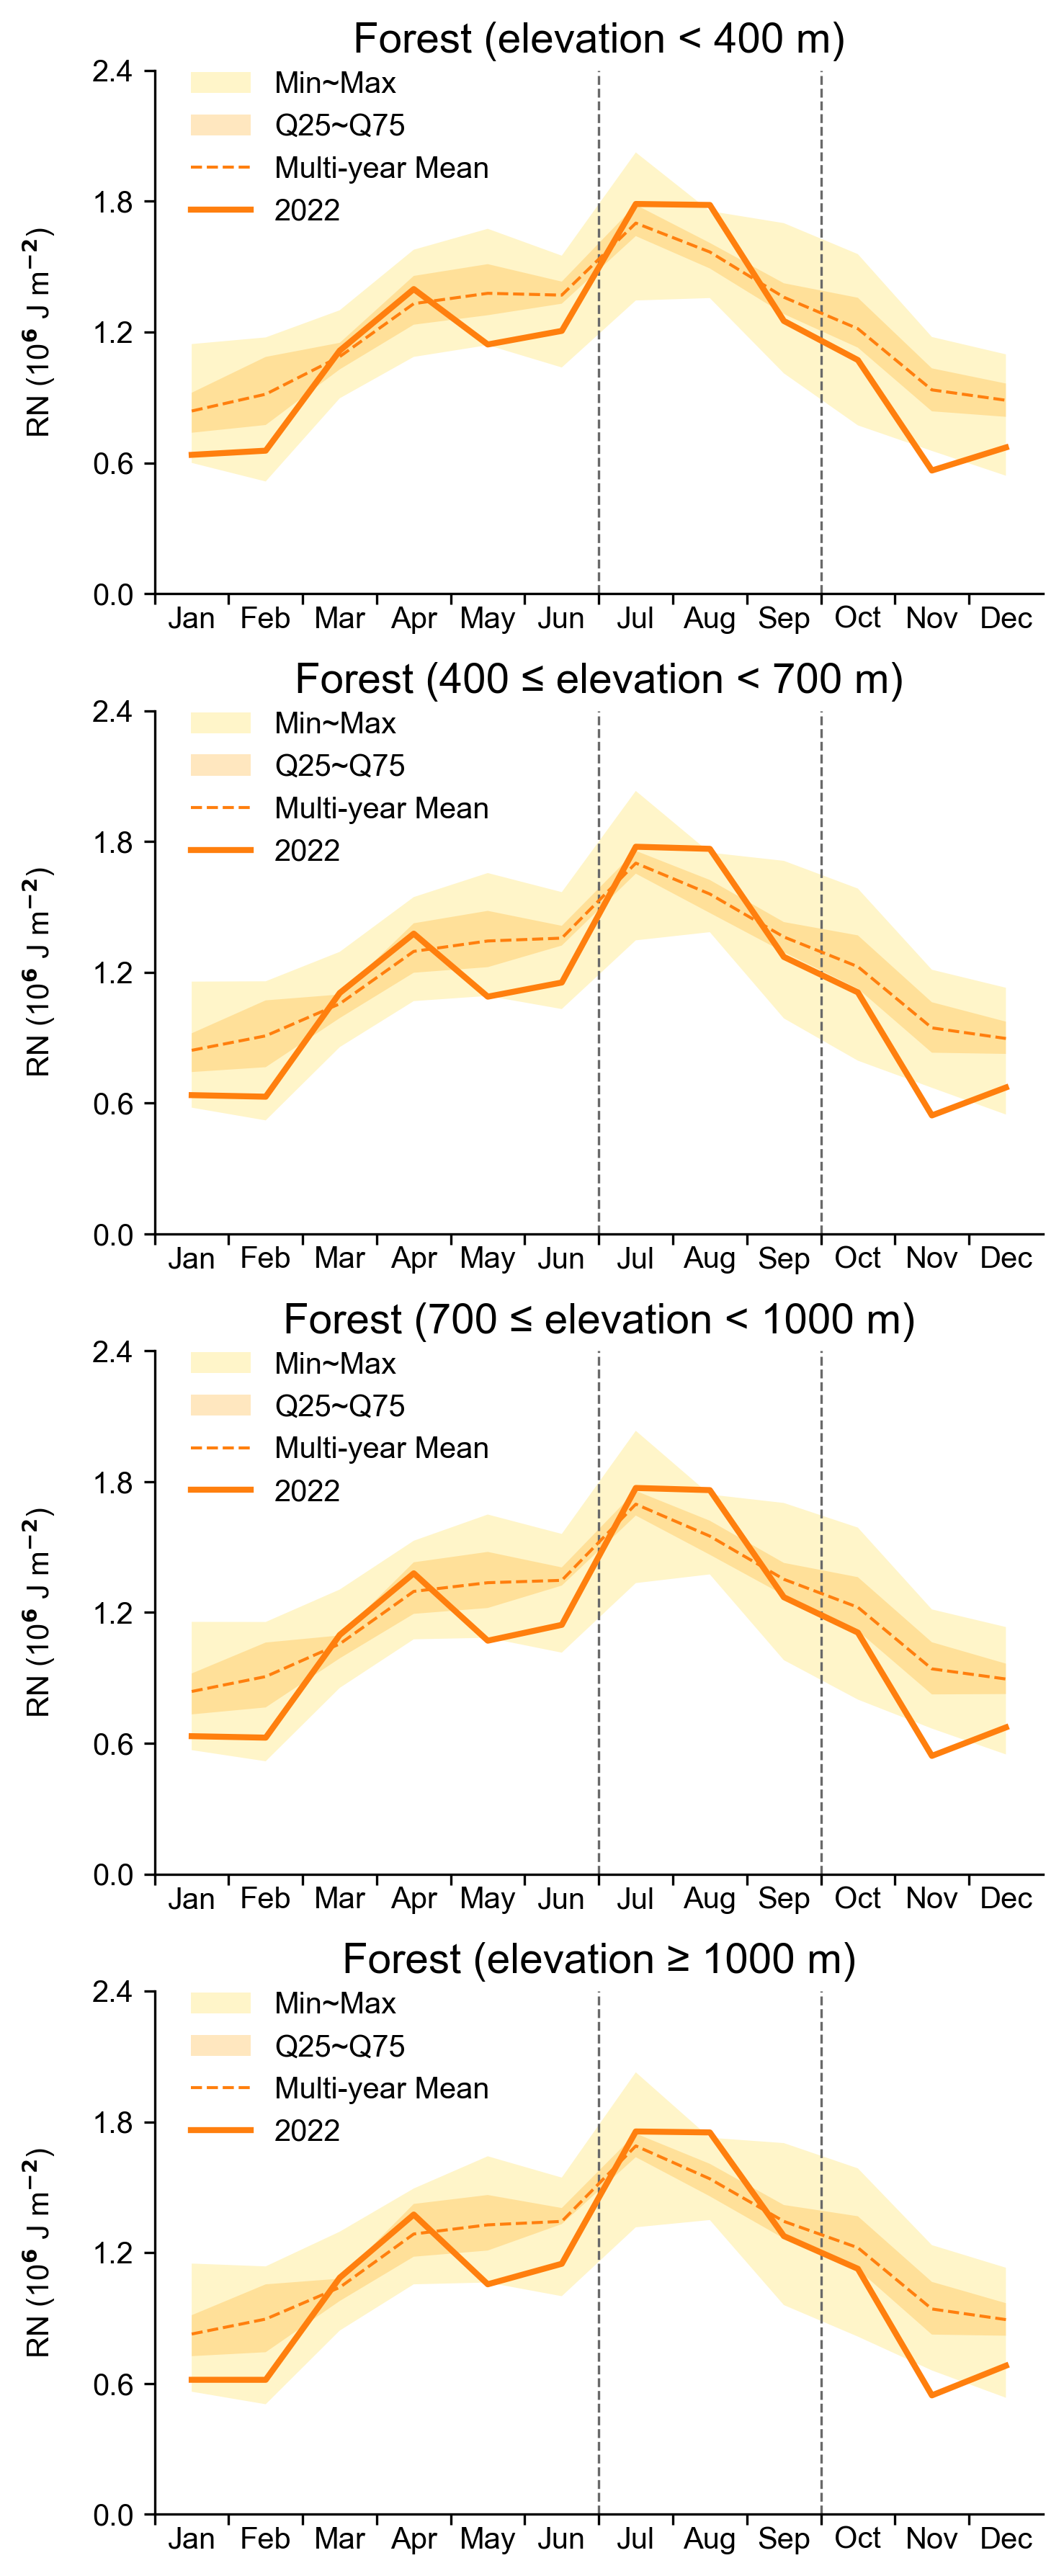

In [10]:
from matplotlib.ticker import MaxNLocator
fig, axes = plt.subplots(4,1,dpi=300,figsize=(5,12))
date = np.arange(1,13)
axes_flat = axes.flatten()
data2 = [b1,b2, b3,b4] ##b-rn
title = [f"Forest (elevation < {ele1} m)",f"Forest ({ele1} ≤ elevation < {ele2} m)",f"Forest ({ele2} ≤ elevation < {ele3} m)", f"Forest (elevation ≥ {ele3} m)"]


for i, ax in enumerate(axes_flat):
    if i < len(data):  # Ensure we don't exceed the number of data arrays
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axvline(x=6.5, color='dimgrey', linestyle='--', lw=0.8)
        ax.axvline(x=9.5, color='dimgrey', linestyle='--', lw=0.8)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_tick_params(labelleft=False, labelright=False)

        ax.fill_between(date, np.nanpercentile(data2[i][:,:-1],q=0,axis=1),np.nanpercentile(data2[i][:,:-1],q=100,axis=1), color='#FFDE4D',alpha=0.3,label='Min~Max',edgecolor='none')
        ax.fill_between(date, np.nanpercentile(data2[i][:,:-1],q=25,axis=1),np.nanpercentile(data2[i][:,:-1],q=75,axis=1), color='#FFB22C',alpha=0.3,label='Q25~Q75',edgecolor='none')
        ax.plot(date,np.nanmean(data2[i][:,:-1],axis=1),lw=1,ls='--',color='tab:orange', label='Multi-year Mean')
        ax.plot(date, data2[i][:,-1],color='tab:orange',lw=2,label='2022')
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_title(title[i], fontsize=14)
        ax.spines['left'].set_position(('outward', 0))
        ax.yaxis.set_ticks_position('left') 
        ax.set_ylabel('RN (10$\mathbf{^{6}}$ J m$\mathbf{^{-2}}$)',labelpad=15)
        ax.yaxis.set_label_coords(-0.11, 0.5)
        ax.set_ylim(0,2.4)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        
        

new_positions = [1,2,3,4,5,6,7,8,9,10,11,12]
xticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for ax in axes_flat:  # Bottom row of subplots
    # Keep the original ticks
    ax.set_xlim(0.5,12.5)
    ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
    ax.set_xticklabels([])  # Hide the default labels

    # Add new labels at the desired positions
    for label, pos in zip(xticklabels, new_positions):
        ax.text(
            pos, 
            ax.get_ylim()[0] - 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]),  # Slightly below the plot
            label, 
            ha='center', 
            va='center', 
            fontsize=10
        )
axes[0].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
axes[1].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
axes[2].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)
axes[3].legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=10)

# plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.tight_layout()
# plt.savefig('/portal1/dell/li-b/manu1_fig/Fig5b.png', dpi=300, bbox_inches='tight') 
plt.show()